# Using Various algorithms of regression and classification 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [2]:
data=pd.read_csv("insurance claim.csv")

In [5]:
pd.set_option('display.max_columns',None) #to see all columns 
data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

## Data Cleaning

In [12]:
data.duplicated().sum()

1

In [13]:
data.drop_duplicates(inplace=True)

In [19]:
#changing data type of currency columns and removing dollar sign
currency_col = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM','CLM_AMT']
def currency_changer(data,columns):
    for col in columns:
        data[col]=data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data=currency_changer(data,currency_col)

In [20]:
#removing the z prefix
zPrefic_col = ['MSTATUS','GENDER','EDUCATION','OCCUPATION','CAR_TYPE']
def zPrefix_remover(data,columns):
    for col in columns:
        data[col]=data[col].replace('[z_]', '', regex=True)
    return data

data=zPrefix_remover(data,zPrefic_col)

In [21]:
data.drop(['ID','BIRTH'],axis=1,inplace=True)

In [25]:
data.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [27]:
columns = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data.rename(columns=columns, inplace=True)

In [31]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1 and vice versa
check1 = (data['new_claim_value'] > 0) & (data['is_claim'] == 0)
data[check1]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


In [30]:
check2 = (data['new_claim_value'] == 0) & (data['is_claim'] == 1)
data[check2]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

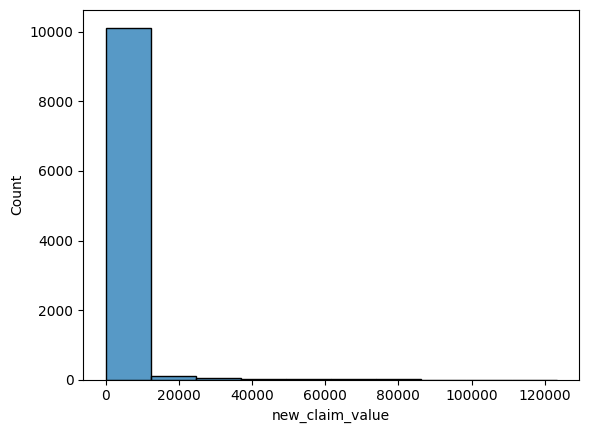

In [33]:
# Create hisogram for new claim value
sns.histplot(data['new_claim_value'], bins=10)

In [34]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data['claim_value_cat'] = pd.cut(data['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='claim_value_cat'>

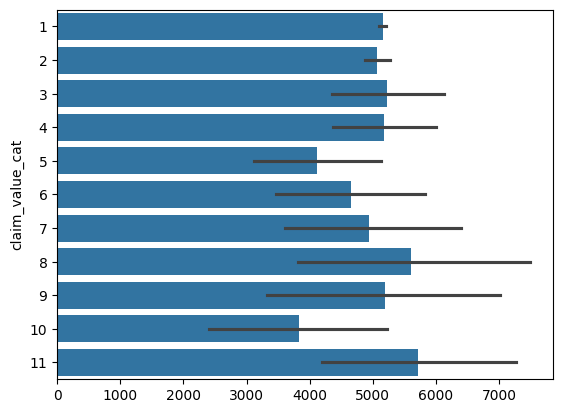

In [36]:
# seeing the distribution of the categories created by bins
sns.barplot(data['claim_value_cat'])

In [41]:
# train test split
X=data.copy()
X.drop(columns=['new_claim_value','is_claim','claim_value_cat'],axis=1,inplace=True)
y=data['is_claim']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
# checking if the ratio is distributed evenly to train and test
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.75%
Test positive class ratio: 26.3%


## Exploratory Data Analysis

### a. EDA data preperation

In [52]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [53]:
# Changing categorical values into binary values 
binary_columns = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
hash_map = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def changeToBinary(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = changeToBinary(eda_test_data, binary_columns, hash_map)

### b. Co-relation Matrix

In [57]:
correlationMatrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)

<Axes: >

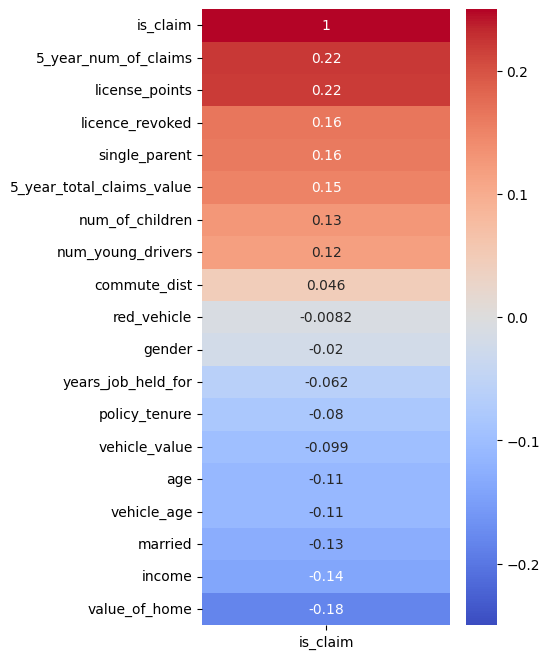

In [61]:
fig, ax = plt.subplots(figsize=(4, 8))
sns.heatmap(correlationMatrix[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

## Data Cleaning and Preprocessing

### a.Dropping unnecessary features

In [62]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

### b.Handling Missing Data

In [65]:
# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

num_young_drivers              0
age                            4
num_of_children                0
years_job_held_for           442
income                       450
single_parent                  0
value_of_home                446
married                        0
gender                         0
highest_education              0
occupation                   529
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  497
address_type                   0
dtype: int64

In [66]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

### c.Numerical feature encoding

In [67]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

In [68]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
2,0,43.0,3,NaN,0,0,45,19680,4,2870,2,2,9.0
3,0,39.0,1,6.0,56014,234014,28,7100,4,0,0,0,NaN
21,0,47.0,0,10.0,64777,237421,47,31120,4,23078,2,3,NaN
23,0,49.0,0,13.0,67489,221734,6,10450,13,11054,1,4,NaN
27,0,42.0,0,NaN,52988,176275,24,23450,1,0,0,2,11.0


In [69]:
# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
2,0.0,43.0,3.0,4.5,0.0,0.0,45.0,19680.0,4.0,2870.0,2.0,2.0,9.0
3,0.0,39.0,1.0,6.0,56014.0,234014.0,28.0,7100.0,4.0,0.0,0.0,0.0,13.5
21,0.0,47.0,0.0,10.0,64777.0,237421.0,47.0,31120.0,4.0,23078.0,2.0,3.0,17.0
23,0.0,49.0,0.0,13.0,67489.0,221734.0,6.0,10450.0,13.0,11054.0,1.0,4.0,11.5
27,0.0,42.0,0.0,11.5,52988.0,176275.0,24.0,23450.0,1.0,0.0,0.0,2.0,11.0


In [70]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

In [71]:
# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
2,No,Yes,F,High School,Student,Commercial,Pickup,No,z_Highly Rural/ Rural
3,No,Yes,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
21,No,No,F,Masters,NaN,Commercial,Van,Yes,Highly Urban/ Urban
23,No,Yes,M,Bachelors,Professional,Private,Pickup,No,Highly Urban/ Urban
27,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,z_Highly Rural/ Rural


In [72]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
2,No,Yes,F,High School,Student,Commercial,Pickup,No,z_Highly Rural/ Rural
3,No,Yes,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
21,No,No,F,Masters,Blue Collar,Commercial,Van,Yes,Highly Urban/ Urban
23,No,Yes,M,Bachelors,Professional,Private,Pickup,No,Highly Urban/ Urban
27,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,z_Highly Rural/ Rural


In [73]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,41.0,0.0,11.0,29541.0,204260.0,45.0,13640.0,10.0,3265.0,2.0,1.0,1.0,No,Yes,M,High School,Manager,Private,Minivan,No,Highly Urban/ Urban
1,0.0,51.0,0.0,13.0,107209.0,258855.0,58.0,17320.0,1.0,0.0,0.0,2.0,11.0,No,Yes,F,PhD,Blue Collar,Commercial,Pickup,No,Highly Urban/ Urban
2,0.0,43.0,3.0,4.5,0.0,0.0,45.0,19680.0,4.0,2870.0,2.0,2.0,9.0,No,Yes,F,High School,Student,Commercial,Pickup,No,z_Highly Rural/ Rural
3,0.0,39.0,1.0,6.0,56014.0,234014.0,28.0,7100.0,4.0,0.0,0.0,0.0,13.5,No,Yes,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
4,0.0,66.0,0.0,15.0,74260.0,277449.0,31.0,15530.0,6.0,0.0,0.0,0.0,11.0,No,Yes,F,Masters,Lawyer,Private,SUV,No,Highly Urban/ Urban


In [83]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

### d.Categorical feature encoding

In [74]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

In [75]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [76]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [77]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [78]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [79]:
# Join numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [80]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

C:\Users\Vaishnavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Vaishnavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.329496
2,age,1.457199
3,num_of_children,2.096667
4,years_job_held_for,1.467729
5,income,2.754472
6,value_of_home,2.163980
7,commute_dist,1.038516
8,vehicle_value,2.067863
9,policy_tenure,1.005073


In [81]:
X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [82]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,74.796992
1,num_young_drivers,1.329496
2,age,1.457199
3,num_of_children,2.096667
4,years_job_held_for,1.467729
5,income,2.754472
6,value_of_home,2.163980
7,commute_dist,1.038516
8,vehicle_value,2.067863
9,policy_tenure,1.005073


## Using various classification models (CLASSIFICATION)

In [86]:
# Storing Model with their name 
clfs =[
    ('Logistic Regression',LogisticRegression(solver='liblinear',max_iter=200)),
    ('KNN',KNeighborsClassifier()),
    ('Decision Tree',DecisionTreeClassifier()),
    ('Random forest Tree',RandomForestClassifier(random_state=42)),
    ('Linear SVM',LinearSVC(random_state=42,max_iter=1000,dual='auto')),
    ('XG Boost',XGBClassifier(random_state=42)),
    ('ADA Boost',AdaBoostClassifier(random_state=42,algorithm='SAMME')),
    ('Gradient Boost',GradientBoostingClassifier(random_state=42)),
    ('Bagging Classifier',BaggingClassifier(random_state=42)),
    ('Cat Boost',CatBoostClassifier(random_state=42,verbose=0))
]

In [87]:
# Creating a Kfold object with 10 fold
kf=KFold(n_splits=10,shuffle=True,random_state=42)

#Storing each models result
result={}

for clf_name,clf in clfs:
    cv_score=cross_val_score(clf,X_train_cleaned,y_train,cv=kf)
    result[clf_name]=cv_score
cv_score_df=pd.DataFrame(result)

Text(0.5, 1.0, 'Cross Validation Score for each Classifier')

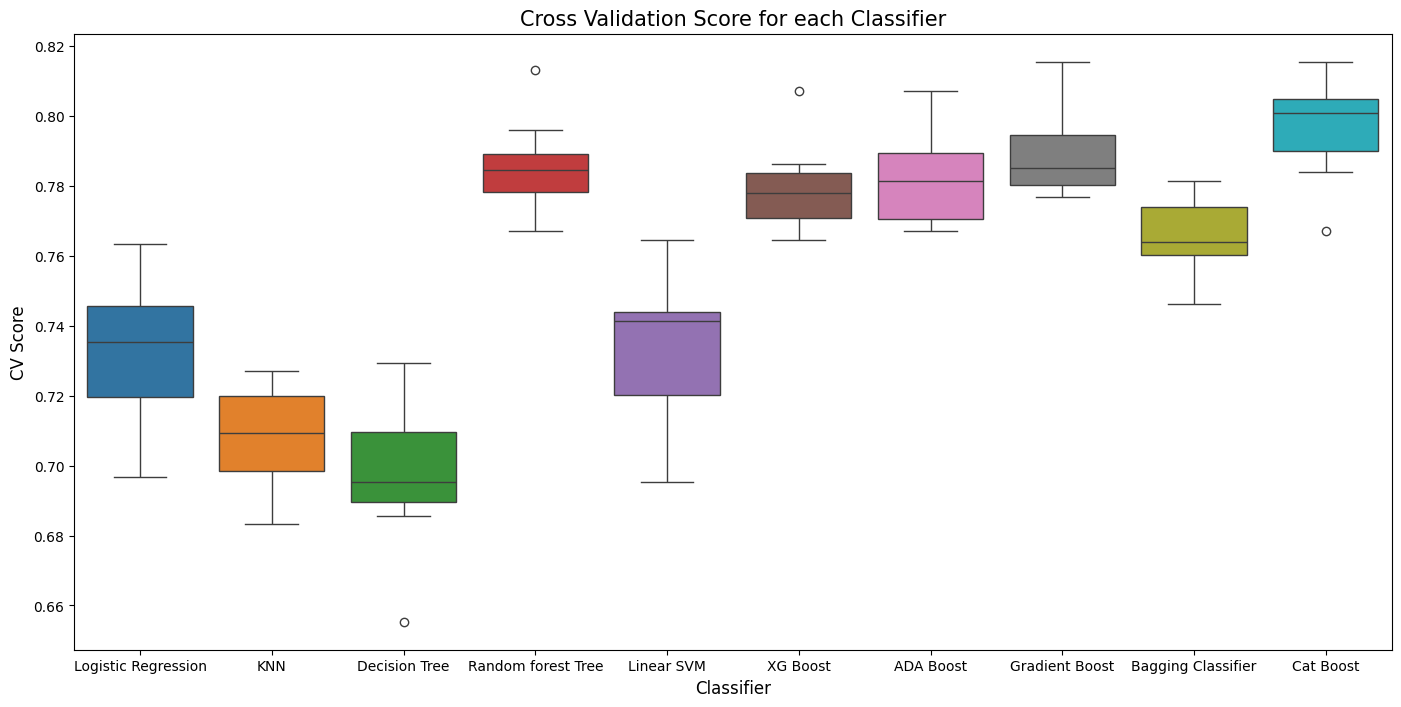

In [93]:
# Plot CV Score
fig,ax=plt.subplots(figsize=(17,8))

sns.boxplot(cv_score_df)

ax.set_xlabel("Classifier",fontsize=12)
ax.set_ylabel('CV Score',fontsize=12)
ax.set_title("Cross Validation Score for each Classifier",fontsize=15)

## Feature engineering

Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. First we'll create histograms for each of the numerical features.

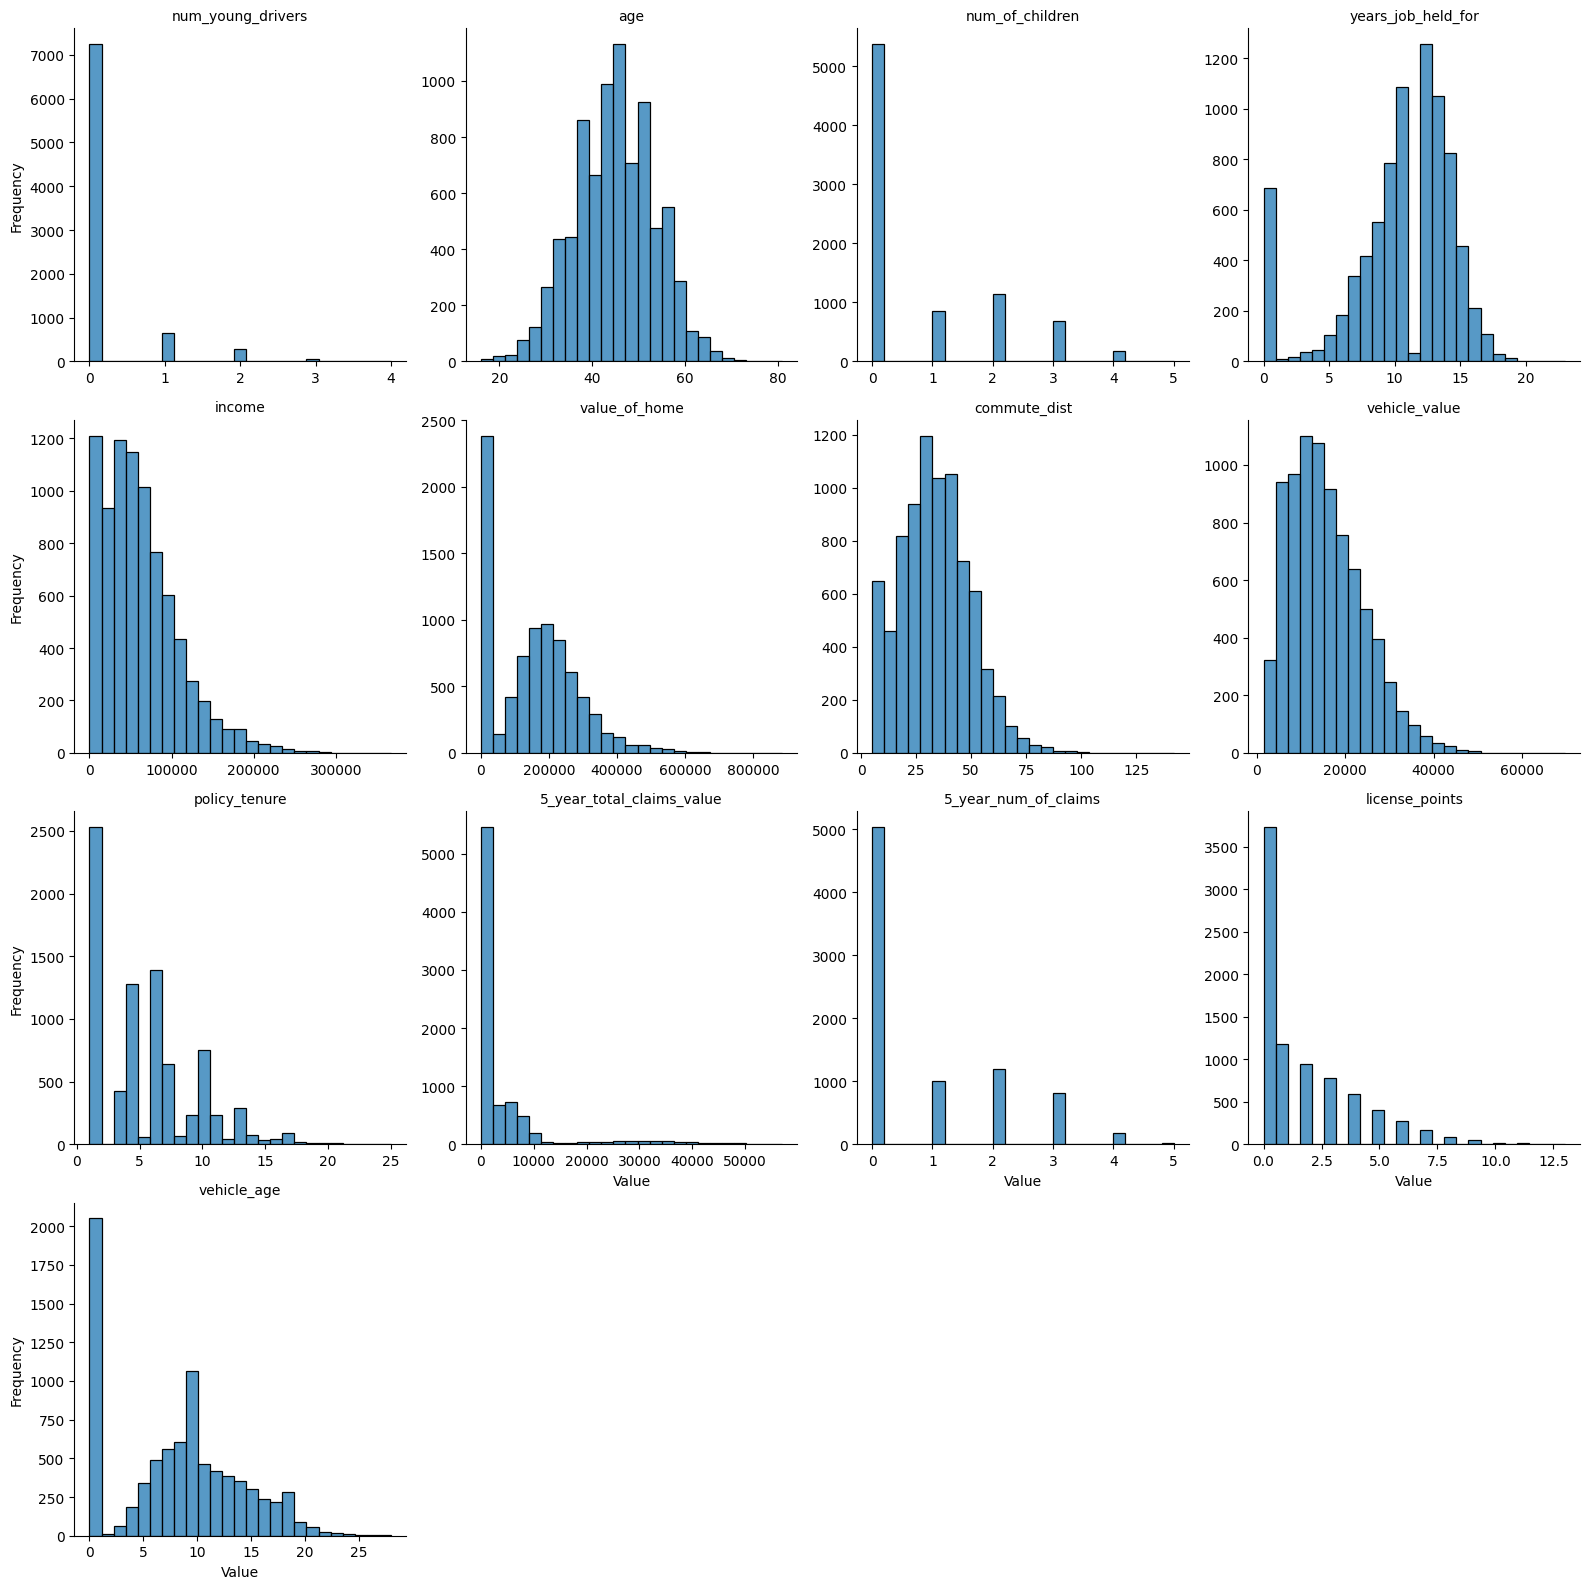

In [94]:
# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

In [95]:
# We can see that some of the features have a right skew. We can try to log transform these features to reduce the skew.
# Define features we right skew
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

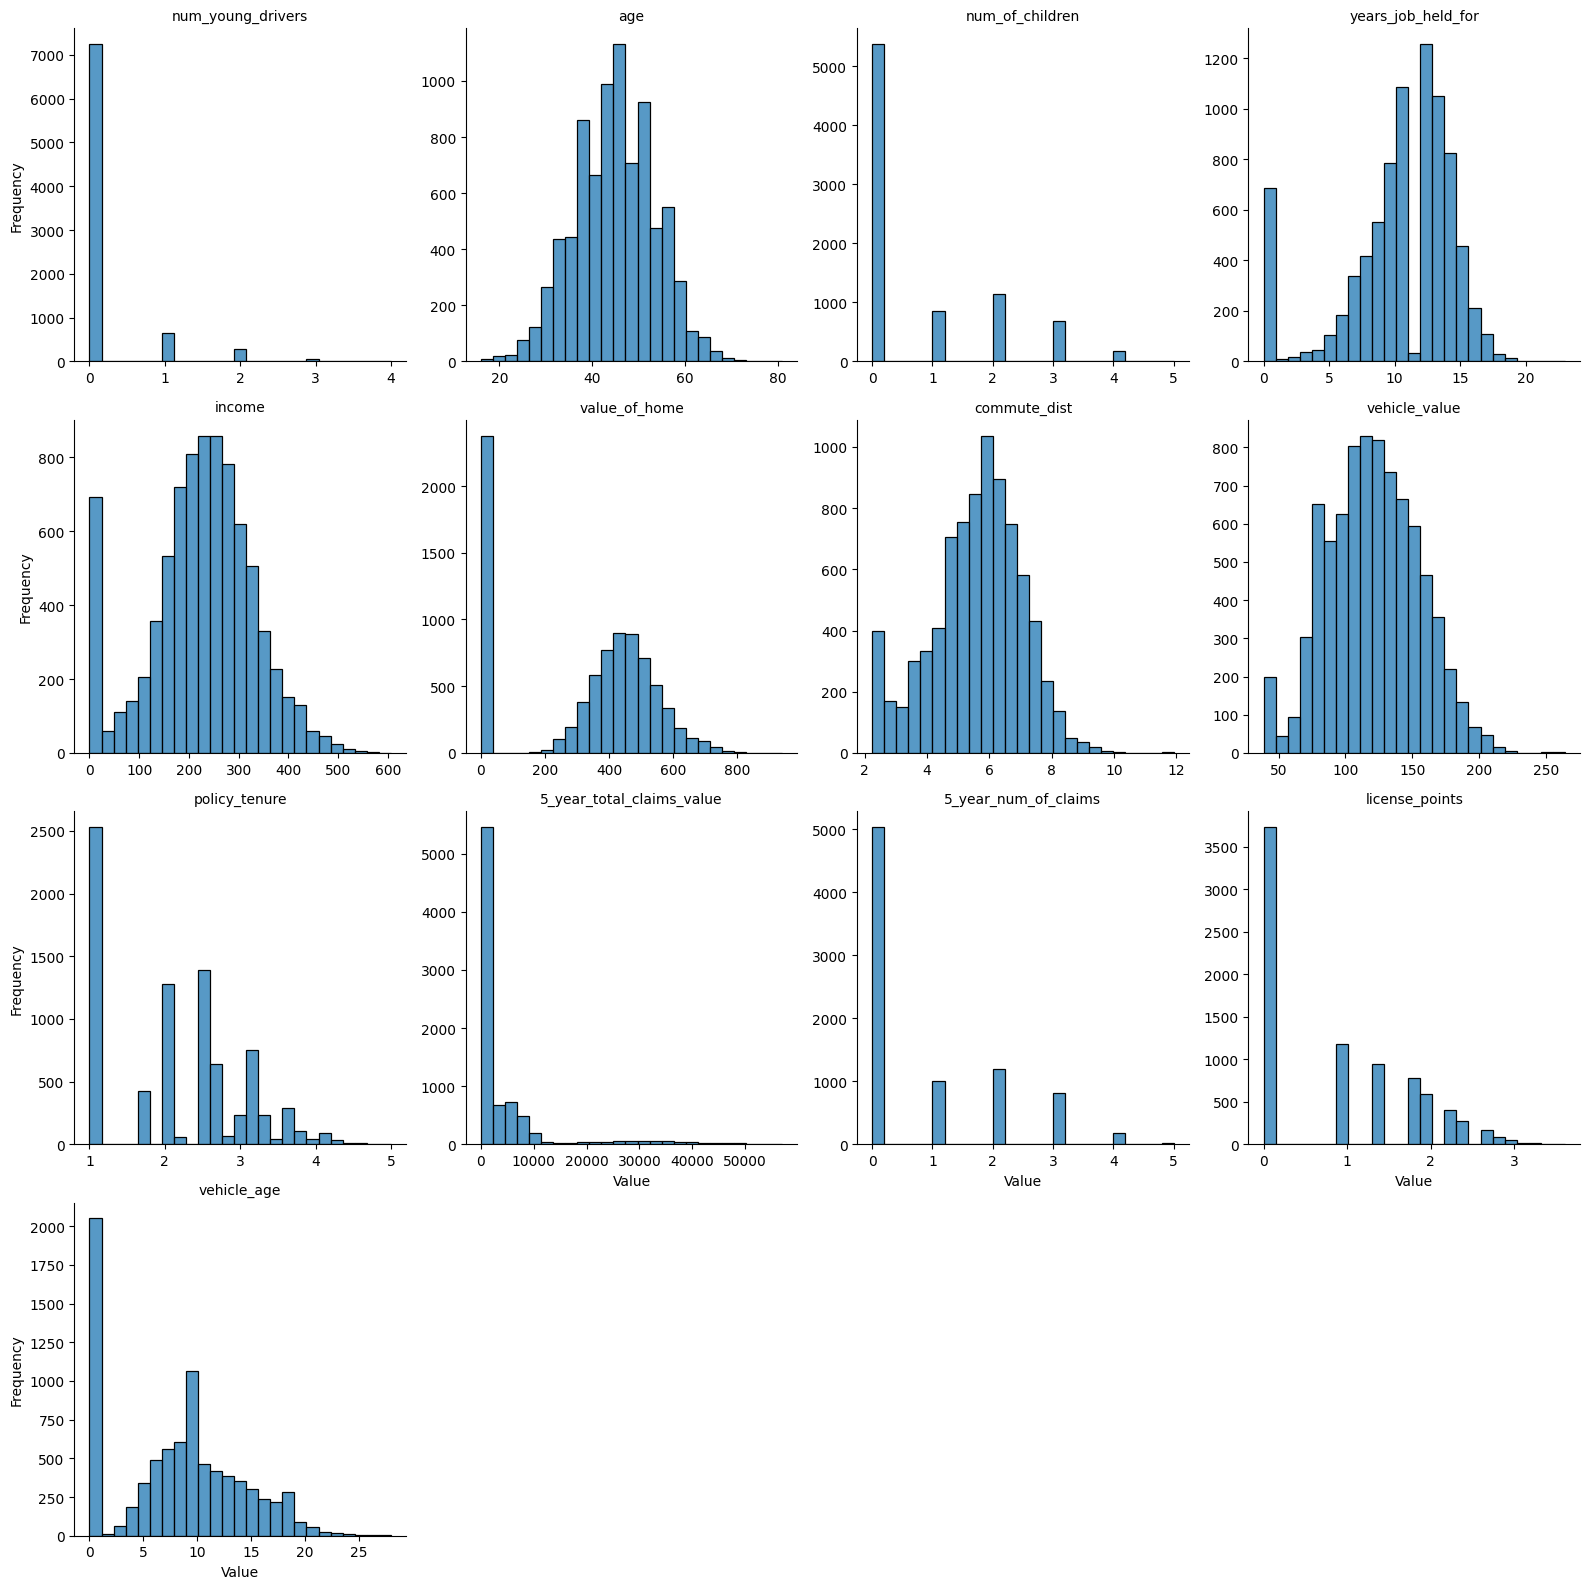

In [96]:
# Checking the distribution after log transformation
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [97]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.7790048543689321
CV score with log transform: 0.7790048543689321


In [98]:
# Feature Scaling
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler to training data
    scaler.fit(data[numeric_features])
    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [99]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.7790048543689321
CV score with log transform: 0.7790048543689321


In [100]:
X_train_cleaned=X_train_cleaned_scaled.copy()

## Model Pipeline

In [101]:
#  Custom Transformation
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [102]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

In [104]:
from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [105]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot),
])

In [106]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [107]:
# Create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out(),
)

# Get names of new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

# Create list of all columns names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Rename df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

# Inspect df
X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.336651,-0.445163,-0.642753,0.140155,-0.488931,0.576396,0.763112,-0.106814,1.147030,-0.091375,1.029852,0.089848,-1.293259,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.336651,0.715035,-0.642753,0.626214,0.967924,0.831062,1.383037,0.324969,-1.236891,-0.462599,-0.694941,0.535316,0.483231,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.336651,-0.213123,2.039815,-1.439538,-2.098652,-1.448999,0.763112,0.577944,-0.134387,-0.136286,1.029852,0.535316,0.127933,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.336651,-0.677202,0.251436,-1.074993,0.117943,0.718900,-0.204581,-1.054863,-0.134387,-0.462599,-0.694941,-0.985609,0.927354,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.336651,2.455332,-0.642753,1.112274,0.453553,0.911532,-0.015877,0.121361,0.361178,-0.462599,-0.694941,-0.985609,0.483231,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.336651,-0.445163,-0.642753,0.140155,-0.488931,0.576396,0.763112,-0.106814,1.147030,-0.091375,1.029852,0.089848,-1.293259,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.336651,0.715035,-0.642753,0.626214,0.967924,0.831062,1.383037,0.324969,-1.236891,-0.462599,-0.694941,0.535316,0.483231,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.336651,-0.213123,2.039815,-1.439538,-2.098652,-1.448999,0.763112,0.577944,-0.134387,-0.136286,1.029852,0.535316,0.127933,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.336651,-0.677202,0.251436,-1.074993,0.117943,0.718900,-0.204581,-1.054863,-0.134387,-0.462599,-0.694941,-0.985609,0.927354,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.336651,2.455332,-0.642753,1.112274,0.453553,0.911532,-0.015877,0.121361,0.361178,-0.462599,-0.694941,-0.985609,0.483231,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Hyperparameter Optimization

In [109]:
# Random Search
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [110]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': 0.9503797514820932, 'gamma': 0.9583276864813868, 'learning_rate': 0.03833510986215996, 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': 0.9860674802096018}
Best cross-validation score:  0.7841006972403796


In [111]:
# Grid Search
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [280, 290, 300],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5, 0.55, 0.6],
    'gamma': [0.05, 0.1, 0.15],
    'min_child_weight': [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [112]:
# Fit the model using RandomizedSearchCV
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.5, 'gamma': 0.15, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 18, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.45}
Best cross-validation score:  0.7849702009848671


In [113]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7790048543689321
XGBoost model score (tuned hyperparamters: 0.7849702009848671


## Model Evaluation

In [114]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [116]:
f1_score(y_test, y_pred, average='weighted')

0.7851234974598953

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

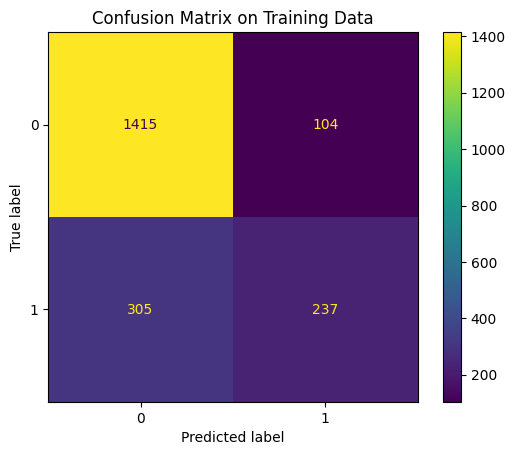

In [117]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

## Using various regression models (REGRESSION)

In [119]:
# Filter to only rows with a non-zero claim value
claim_data = data[data['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [120]:
# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

In [121]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

In [122]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

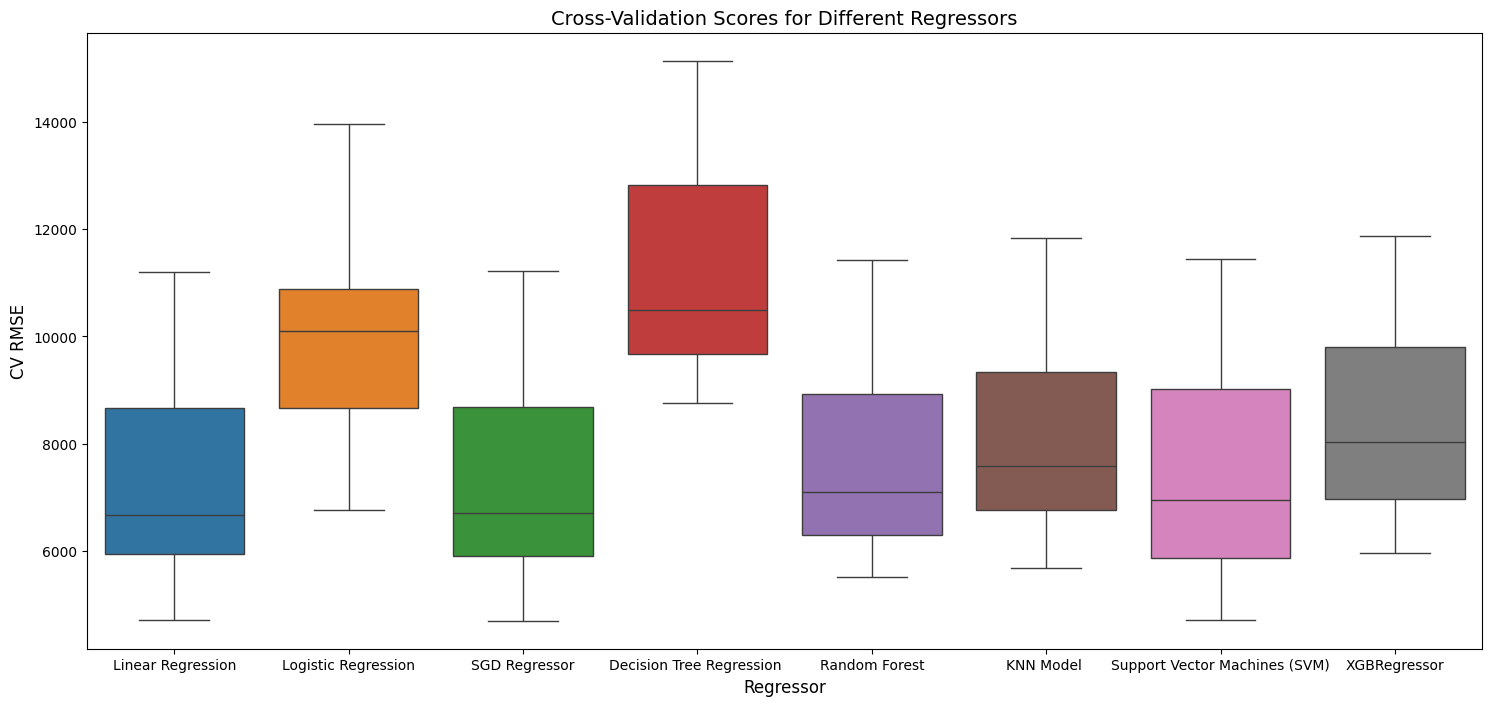

In [126]:
# Plot scores
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

In [124]:
# Hyperparameter Optimization
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [133]:
# Fit the model using RandomizedSearchCV
reg_random_search.fit(X_reg_train_prepared, y_reg_train)

score = np.sqrt(-random_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", score)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters found:  {'colsample_bytree': 0.9503797514820932, 'gamma': 0.9583276864813868, 'learning_rate': 0.03833510986215996, 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': 0.9860674802096018}
Best cross-validation score:  nan


C:\Users\Vaishnavi\AppData\Local\Temp\ipykernel_42708\2748580657.py:4: RuntimeWarning: invalid value encountered in sqrt
  score = np.sqrt(-random_search.best_score_)


In [134]:
# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.004, 0.008, 0.012],
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.003, 0.005],
    'max_iter': [180, 200, 220],
    'tol': [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [135]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best parameters found:  {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}
Best cross-validation score:  7601.031780043568


In [137]:
# Model Evaluation
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 8381.297332645316
MAE: 3546.227497403612
